For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:

Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3

http://jse.amstat.org/v19n3/decock.pdf

https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

# DecisionTreeDiscretiser

The DecisionTreeDiscretiser() divides continuous numerical variables into discrete,
finite, values estimated by a decision tree.

The methods is inspired by the following article from the winners of the KDD
2009 competition:
http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf

At the moment, this transformer only works for binary classification or
regression. Multi-class classification is not supported.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,5]

In [2]:
data = pd.read_csv('housing.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# let's separate into training and testing set
X = data.drop(["Id","SalePrice"], axis=1)
y = data.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train :" ,X_train.shape)
print("X_test :" ,X_test.shape)

X_train : (1022, 79)
X_test : (438, 79)


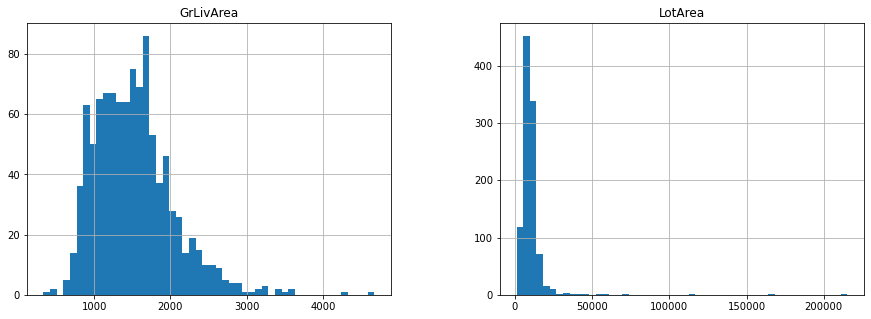

In [4]:
# we will use two continuous variables for transformation
X_train[["LotArea", 'GrLivArea']].hist(bins=50)
plt.show()

The DecisionTreeDiscretiser() works only with numerical variables.
A list of variables can be passed as an argument. Alternatively, the
discretiser will automatically select all numerical variables.

The DecisionTreeDiscretiser() first trains a decision tree for each variable,
fit.

The DecisionTreeDiscretiser() then transforms the variables, that is,
makes predictions based on the variable values, using the trained decision
tree, transform.

In [6]:
'''
Parameters
----------

cv : int, default=3
    Desired number of cross-validation fold to be used to fit the decision
    tree.

scoring: str, default='neg_mean_squared_error'
    Desired metric to optimise the performance for the tree. Comes from
    sklearn metrics. See DecisionTreeRegressor or DecisionTreeClassifier
    model evaluation documentation for more options:
    https://scikit-learn.org/stable/modules/model_evaluation.html

variables : list
    The list of numerical variables that will be transformed. If None, the
    discretiser will automatically select all numerical type variables.

regression : boolean, default=True
    Indicates whether the discretiser should train a regression or a classification
    decision tree.

param_grid : dictionary, default=None
    The list of parameters over which the decision tree should be optimised
    during the grid search. The param_grid can contain any of the permitted
    parameters for Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier().

    If None, then param_grid = {'max_depth': [1, 2, 3, 4]}

random_state : int, default=None
    The random_state to initialise the training of the decision tree. It is one
    of the parameters of the Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier(). For reproducibility it is recommended to set
    the random_state to an integer.
'''

treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='neg_mean_squared_error',
                                   variables=['LotArea', 'GrLivArea'],
                                   regression=True)

# the tree discretisers needs the target for fitting
treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(param_grid={'max_depth': [1, 2, 3, 4]},
                        variables=['LotArea', 'GrLivArea'])

In [7]:
# the binner contains the best decision tree for each variable
treeDisc.binner_dict_

{'LotArea': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
              param_grid={'max_depth': [1, 2, 3, 4]},
              scoring='neg_mean_squared_error'),
 'GrLivArea': GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
              param_grid={'max_depth': [1, 2, 3, 4]},
              scoring='neg_mean_squared_error')}

In [8]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [9]:
# the below account for the best obtained bins, aka, the tree predictions

train_t['GrLivArea'].unique()

array([246372.77165354, 149540.32663317, 122286.38839286,  88631.59375   ,
       165174.20895522, 198837.68608414, 312260.5       , 509937.5       ])

In [10]:
# the below account for the best obtained bins, aka, the tree predictions

train_t['LotArea'].unique()

array([181711.59622642, 145405.30751708, 213802.86363636, 251997.13333333])

In [11]:
# here I put side by side the original variable and the transformed variable
tmp = pd.concat([X_train[["LotArea", 'GrLivArea']], train_t[["LotArea", 'GrLivArea']]], axis=1)
tmp.columns = ["LotArea", 'GrLivArea',"LotArea_binned", 'GrLivArea_binned']
tmp.head()

,LotArea,GrLivArea,LotArea_binned,GrLivArea_binned
64,9375,2034,181711.596226,246372.771654
682,2887,1291,145405.307517,149540.326633
960,7207,858,145405.307517,122286.388393
1384,9060,1258,181711.596226,149540.326633
1100,8400,438,145405.307517,88631.593750


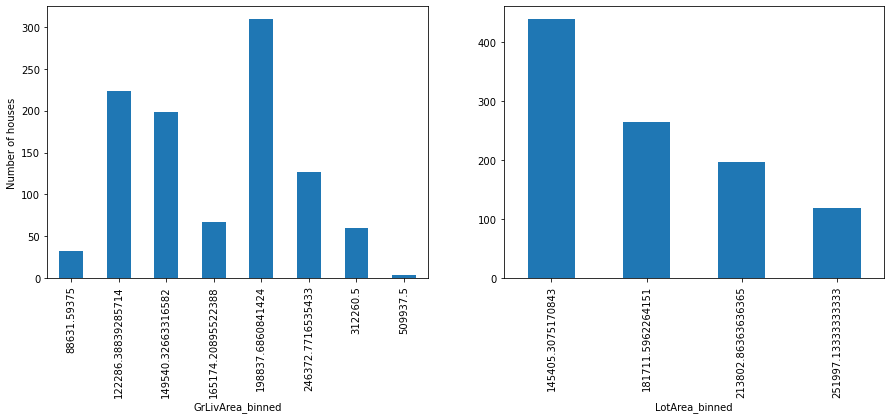

In [12]:
# in  equal frequency discretisation, we obtain the same amount of observations
# in each one of the bins.
plt.subplot(1,2,1)
tmp.groupby('GrLivArea_binned')['GrLivArea'].count().plot.bar()
plt.ylabel('Number of houses')
plt.subplot(1,2,2)
tmp.groupby('LotArea_binned')['LotArea'].count().plot.bar()

plt.show()

## Decision tree discretiser for classfication

In [13]:
# Load titanic dataset from OpenML

def load_titanic():
    data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['embarked'].fillna('C', inplace=True)
    data['fare'] = data['fare'].astype('float').fillna(0)
    data['age'] = data['age'].astype('float').fillna(0)
    return data

In [15]:
# load data
data = load_titanic()
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [17]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['survived', 'name', 'ticket'], axis=1),
                                                    data['survived'],
                                                    test_size=0.3, 
                                                    random_state=0)

print(X_train.shape)
print(X_test.shape)

(916, 11)
(393, 11)


In [19]:
#this discretiser transforms the numerical variables
X_train[['fare', 'age']].dtypes

fare    float64
age     float64
dtype: object

In [21]:
treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='roc_auc',
                                   variables=['fare', 'age'],
                                   regression=False)

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(param_grid={'max_depth': [1, 2, 3, 4]},
                        regression=False, scoring='roc_auc',
                        variables=['fare', 'age'])

In [22]:
treeDisc.binner_dict_

{'fare': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
              param_grid={'max_depth': [1, 2, 3, 4]}, scoring='roc_auc'),
 'age': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
              param_grid={'max_depth': [1, 2, 3, 4]}, scoring='roc_auc')}

In [23]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [24]:
# the below account for the best obtained bins
# in this case, the tree has found that dividing the data in 6 bins is enough
train_t['age'].unique()

array([0.39072848, 0.58974359, 0.26857143, 0.51162791, 0.        ,
       1.        ])

In [25]:
# the below account for the best obtained bins
# in this case, the tree has found that dividing the data in 8 bins is enough
train_t['fare'].unique()

array([0.43333333, 0.24444444, 0.34337349, 0.73684211, 0.75925926,
       0.44444444, 0.33333333, 0.16129032, 0.        , 0.05882353,
       0.88888889, 1.        , 0.70967742, 0.5       ])

In [27]:
# here I put side by side the original variable and the transformed variable
tmp = pd.concat([X_train[["fare", 'age']], train_t[["fare", 'age']]], axis=1)
tmp.columns = ["fare", 'age',"fare_binned", 'age_binned']
tmp.head()

,fare,age,fare_binned,age_binned
501,19.5000,13.0,0.433333,0.390728
588,23.0000,4.0,0.433333,0.589744
402,13.8583,30.0,0.244444,0.390728
1193,7.7250,0.0,0.343373,0.268571
686,7.7250,22.0,0.343373,0.390728


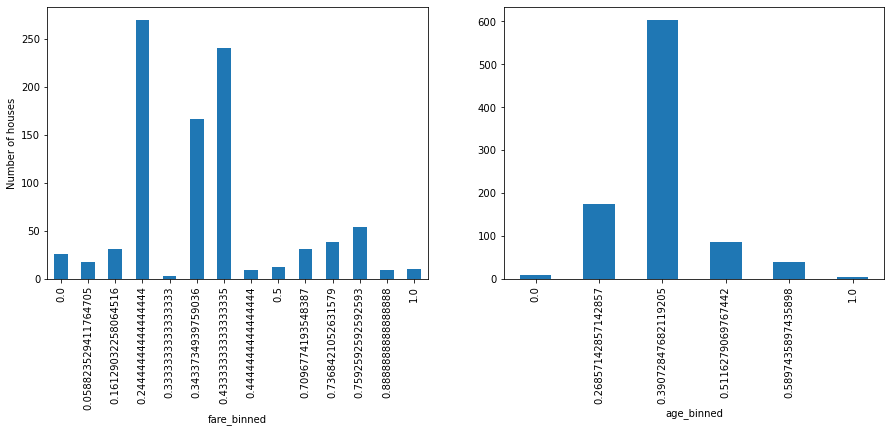

In [29]:
# in  equal frequency discretisation, we obtain the same amount of observations
# in each one of the bins.
plt.subplot(1,2,1)
tmp.groupby('fare_binned')['fare'].count().plot.bar()
plt.ylabel('Number of houses')
plt.subplot(1,2,2)
tmp.groupby('age_binned')['age'].count().plot.bar()

plt.show()